In [2]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import layers
import matplotlib.pyplot as plt
import time # modeli yaddaşa verərkən lazımdır

In [3]:
# keras-ın Callback classını override edərək öz istədiyimiz funksionallığı burada qeyd edirik.
class Xetle(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print(str(epoch) + ', ', end='')


        
# Bu funksiya vasitəsilə məşğələ nəticəsinin qrafikini çəkirik
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Ortalamanın mütləq xətası [AZN]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Məşğələ Xətası')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Dəyər Xətası')
  plt.legend()
#   plt.ylim([0,5])
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Otralamanın Kvadrat Xətası[AZN^2]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Məşğələ Xətası')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Dəyər Xətası')
  plt.legend()


In [4]:
# pandas seçimləri - bunlar olmadan pandas dataları haqqında məlumatı ekrana yazdıranda məlumatlar icmal formasında görünür.
# Bunları # işarəsi ilə comment edə bilərsiniz. Mən məlumatları tam görmək istədiyim üçün bunları saxlayıram.

# Maksimal sətirlərin sayı
pd.set_option('display.max_rows', 5000)
# Maksimal sütunların sayı
pd.set_option('display.max_columns', 5000)
# Enin uzunluğu
pd.set_option('display.width', 1000)

In [5]:
# Bizə lazım olan məlumat, bütün analiz buradakı məlumatlara əsasən aparılacaq
car_data = '07_FULL_LIST.csv'

In [6]:
# csv faylında sütun adları olmadığı üçün onları əlavə edirik. Adları özüm ingilis diliində təyin etmişəm. Siz stədiyinizi yazın
column_names = ['car_name', 'price', 'year', 'engine', 'mileage', 'valyuta']

# faylı parse edirik və məlumatları pandas dataframe formatına çeviririk.
raw_dataset = pd.read_csv(car_data, names=column_names, na_values = "?", comment='\t', sep=",", skipinitialspace=True,
                          encoding='ISO-8859-1')
dataset = raw_dataset.copy()

In [7]:
# .head datasetdə ilk sətirləri, .tail() isə datasetdə son sətirləri ekrana çıxarır.
dataset.head()

,car_name,price,year,engine,mileage,valyuta
0,LADA (VAZ) 2107,6900,2012,1.6,10900,AZN
1,LADA (VAZ) 2107,6100,2010,1.6,151365,AZN
2,LADA (VAZ) 2107,6600,2010,1.6,150000,AZN
3,LADA (VAZ) 2107,3100,2000,1.6,165000,AZN
4,LADA (VAZ) 2107,3900,2003,1.6,250000,AZN


In [8]:
# Maşın adı və valyuta sütunlarını siyahıdan çıxarırıq. 
# Çünki, onlar bütü sətirlərdə eynidir. İstəsəniz motor ölçüsünü də çıxara bilərsiniz.
dataset.pop('car_name')
dataset.pop('valyuta')
# Sütunları çıxdıqdan sonra məlumata baxaq və əmin olaq ki, sütunlar yoxdur.
dataset.head()

,price,year,engine,mileage
0,6900,2012,1.6,10900
1,6100,2010,1.6,151365
2,6600,2010,1.6,150000
3,3100,2000,1.6,165000
4,3900,2003,1.6,250000


In [9]:
# Beləliklə əmin oluruq ki, məlumatların hamısı tamdır. Yəni, hər hansı bir sətirdə və ya sütunda məlumat çatışmazlığı yoxdur.
dataset.isna().sum()

price      0
year       0
engine     0
mileage    0
dtype: int64

In [10]:
# Burada məşğələ üçün datasetimizi yaradırıq, bu zaman ümumi dataseti 80 faiz həcmində məlumatı məşğələ üçün ayırırıq
train_dataset = dataset.sample(frac=0.8,random_state=0)
# Burada test dataseti hazırlayırıq, bu zaman ümumi datasetdən məşğələ datasetini çıxırıq və yerdə qalanı test üçün saxlayırıq
test_dataset = dataset.drop(train_dataset.index)

c:\users\hp\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


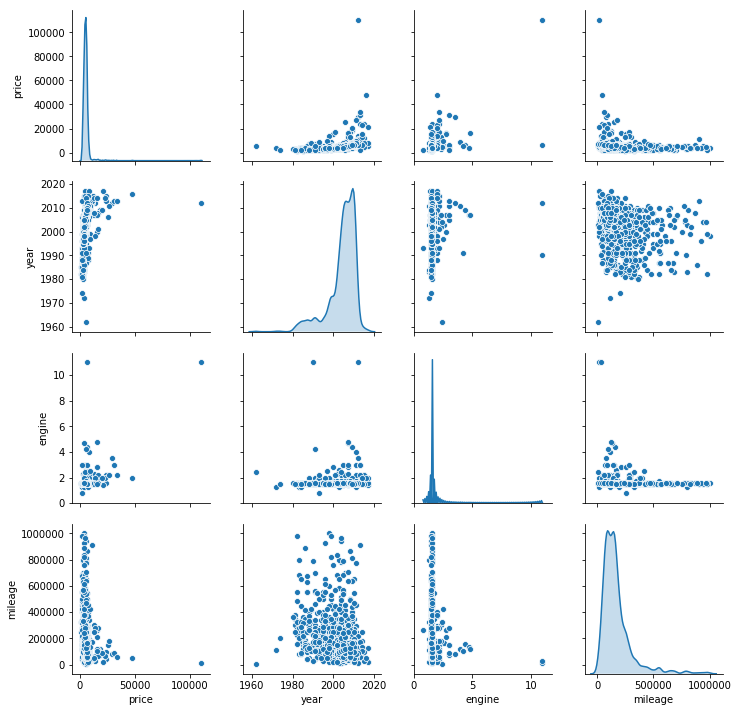

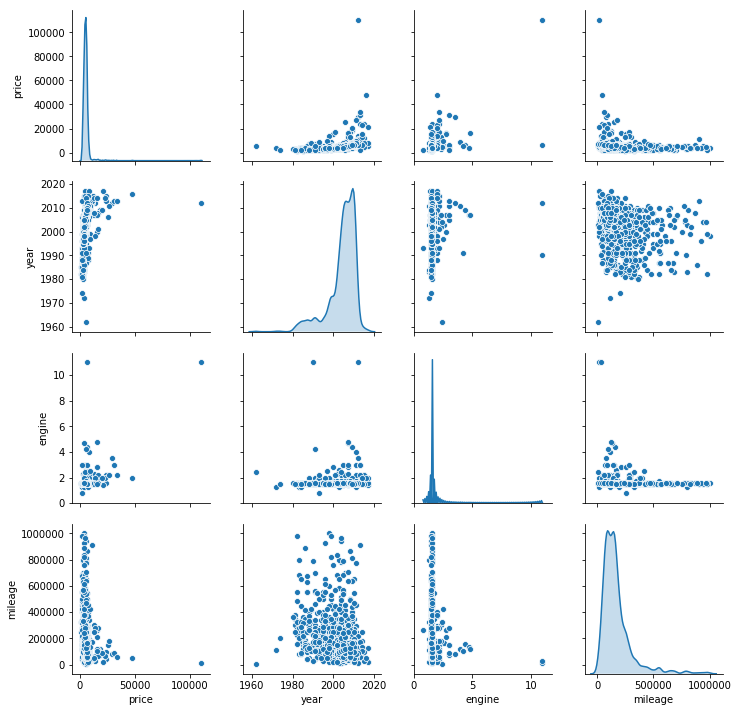

In [11]:
# Məlumatı vizualizasiya edirik
sns_plot = sns.pairplot(train_dataset[["price", "year", "engine", "mileage"]], diag_kind="kde")
sns.pairplot(train_dataset[["price", "year", "engine", "mileage"]], diag_kind="kde")
# Şəkli yaddaşa veririk.
sns_plot.savefig('output_07_LADA.png')

In [12]:
# Məşğələ məlumatlarına baxırıq
train_dataset.describe()

,price,year,engine,mileage
count,1463.000000,1463.000000,1463.000000,1463.000000
mean,5629.907724,2004.494190,1.620369,172558.144908
std,3854.901838,6.800745,0.410592,136631.991076
min,1500.000000,1962.000000,0.800000,4000.000000
25%,4300.000000,2003.000000,1.600000,90384.500000
50%,5300.000000,2006.000000,1.600000,144444.000000
75%,6350.000000,2009.000000,1.600000,200000.000000
max,110000.000000,2017.000000,11.000000,999999.000000


In [13]:
# Test məlumatlarına baxırıq.
test_dataset.describe()

,price,year,engine,mileage
count,366.000000,366.000000,366.000000,3.660000e+02
mean,5565.081967,2004.005464,1.618306,1.854265e+05
std,3608.531248,7.252395,0.272419,2.028823e+05
min,1500.000000,1981.000000,1.300000,2.000000e+03
25%,4200.000000,2003.000000,1.600000,9.000000e+04
50%,5200.000000,2006.000000,1.600000,1.450645e+05
75%,6200.000000,2009.000000,1.600000,2.073468e+05
max,46800.000000,2019.000000,4.600000,2.884486e+06


In [14]:
# qiyməti siyahıdan çıxırıq və məlumatlara baxırıq.
train_stats = train_dataset.describe()
train_stats.pop("price")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,1463.0,2004.494190,6.800745,1962.0,2003.0,2006.0,2009.0,2017.0
engine,1463.0,1.620369,0.410592,0.8,1.6,1.6,1.6,11.0
mileage,1463.0,172558.144908,136631.991076,4000.0,90384.5,144444.0,200000.0,999999.0


In [15]:
# Biz burada qiyməti tapacağımıza görə həm train, həm də test dataset-dən price sütununu silməliyik.
train_labels = train_dataset.pop('price')
test_labels = test_dataset.pop('price')

In [16]:
# Normallaşdırıcı funksiya
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

# məşğələ və test dataseti normallaşdırırıq
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
# Aşağıdakı ikisini comment etsəniz, bu zaman real normallaşdırılmış məlumat işə düşəcəkdir.
normed_train_data = train_dataset
normed_test_data = test_dataset

In [17]:
# Model hazırlamaq üçün funksiya. Burada əlbəttə ki, layer qatlarını parametrləşdirərək, funksiya ilə təyin edə bilərik.
# Hələlik isə belə sadə qalsın.
def build_model():
    model = keras.Sequential()
    model.add(layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]))
    model.add(layers.Dense(64, activation=tf.nn.relu))
    model.add(layers.Dense(1)) 
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

In [18]:
# Modelimizi düzəldirik
model = build_model()

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,481
Trainable params: 4,481
Non-trainable params: 0
_________________________________________________________________


In [20]:
# normallaşdırılmış datasetdə hər hansı bir boşluq varsa, onları 0 ilə əvəzləyirik
normed_train_data.fillna(0, inplace=True)
# Məlumat belə görünür
normed_train_data[:10]

,year,engine,mileage
665,2008,1.6,90000
536,2006,1.5,121112
53,2000,1.6,45000
215,2012,1.6,61000
1783,2007,1.5,92000
1116,1994,1.6,150000
965,2011,1.6,95000
465,2011,4.0,118000
442,1999,1.6,190700
438,2008,1.7,123456


In [21]:
# test datadan 10 sətir götürüb modelimizi test edirik. Nəticədə qiymətlər çıxır. Deyə bilərik ki, model funksionaldır.
example_batch = normed_test_data[:10]
example_result = model.predict(example_batch)
print(example_result)

[[ -9123.381]
 [ -9728.463]
 [-13307.748]
 [-21389.678]
 [ -6509.517]
 [-11039.348]
 [ -8723.408]
 [ -9656.877]
 [ -8723.461]
 [ -3455.65 ]]


In [22]:
# epoch dataset üzərində məşğələlərin sayını bildirir. Yəni, 1 epoch modelin bütün məlumatları 1 dəfə "görməsi" deməkdir.
# Bizim modeldə 3750 daha yaxşı görünür, ona görə də bu rəqəmi qeyd etmişəm.
epoch = 10

# Aşağıdakı qrafikə baxanda aydın olur ki, xəta payı müəyyən epoch sayından sonra x xəttinə paralel gedir. Bu o deməkdir ki,
# modelin öyrənməyində artıq heç bir inkişaf yoxdur. Yəni, xəta payı daha da aşağı enmir. (Qrafikə baxanda aydın olur ki. 
# xəta payı yuxarıdan başlayır və epoch sayı artıqca aşağı doğru hərəkət edir və bir nöqtədə aşağı hərəkətini saxlayır,
# y xəttinə paralel gedir. Bundan sonra modelin öyrənməsinə gərək qalmır. early_stop bu nöqtəni təyin edir və modelin 
# öyrənmə prosesini dayandırır.)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# modeli burada öyrədirik və bütün məlumatı history dəyişkənində saxlayırıq.
history = model.fit(
  normed_train_data, train_labels,
  epochs=epoch, validation_split = 0.2, verbose=0,
  callbacks=[Xetle()])

# Modeli yaddaşa vermək üçün. Sonluğu .model kimi təyin eləmişəm. Siz istədiyiniz kimi təyin edə bilərsiniz. Çox hallarda
# h5py kimi qeyd edirlər. Yaddaşa verdikdən sonra modeli daha sonra load_model() metodu ilə yükləyib istifadə edə bilərsiniz.
model.save('modelin-adi-' + str(int(time.time())) + '.model')
# early_stop modelin öyrənilməsi ərzində deqradasiya gedərsə öyrənmə prosesini avtomatik dayandırır. Bu parametri silərək modeli
# tam öyrədə bilərsiniz. Bu zaman isə overfitting əmələ gələcək. Overfitting haqqında isə daha sonra ətraflı yazacam

# Aşağıda testlər apararaq minimal uzaqlaşma xətasını tapmağa çalışmışam.
# epoch(3750) = 975.94
# epoch(4000) = 983.17
# epoch(3800) = 981.18
# epoch(3700) = 993.35
# epoch(3760) = 999.12

# Nəticədə 3750 istifadə etdim



0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 

In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,val_loss,val_mean_absolute_error,val_mean_squared_error,loss,mean_absolute_error,mean_squared_error,epoch
5,3.680031e+07,3530.904334,3.680031e+07,3.640063e+07,3867.522008,3.640063e+07,5
6,2.345189e+07,2886.502739,2.345189e+07,3.963919e+07,4080.964789,3.963919e+07,6
7,3.108408e+07,3205.151623,3.108408e+07,3.475832e+07,3662.981500,3.475832e+07,7
8,2.254811e+07,2719.081531,2.254811e+07,3.595602e+07,3556.021931,3.595602e+07,8
9,2.118566e+07,2595.958938,2.118566e+07,3.465786e+07,3716.177613,3.465786e+07,9


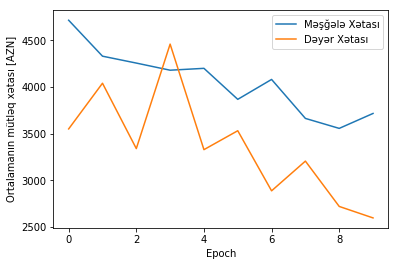

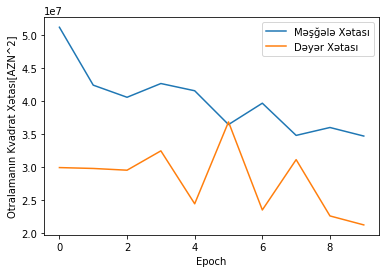

In [24]:
# Aşağıdakı qrafikdə də görünür ki, müəyyən epoch sayından sonra mütləq xəta azalmır və epoch ilə paralel gedir.
plot_history(history)

Mütləq xəta ortalaması: 2854.55 AZN


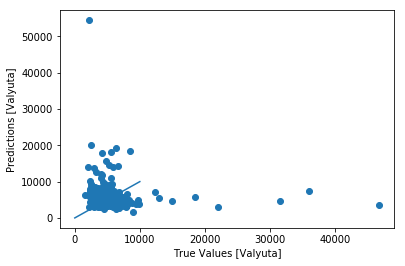

In [25]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

# Yəni, əldə etdiyimiz nəticə bu rəqəm qədər artıq və ya az ola bilər :) 
# Nə qədər aşağı olsa deməli model o qədər də yaxşı işləyir
print("Mütləq xəta ortalaması: {:5.2f} AZN".format(mae))

test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Valyuta]')
plt.ylabel('Predictions [Valyuta]')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# _ = plt.plot([-100, 100], [-100, 100])
plt.plot([0, 10000], [0, 10000])


# Yenə də qrafikə baxanda aydın olur ki, hələ görüləcək işlərimiz çoxdur. Yəni modeli çox optimallaşdırmalıyıq.
# Xəttimiz tam olaraq da paylanmanı təmsil etmir. Bir az daha əyri xətt daha yaxşı olardı. 

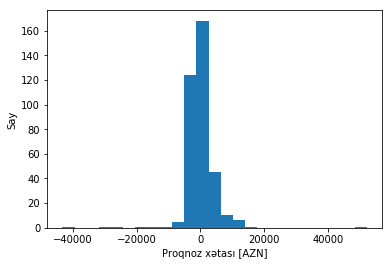

In [26]:
# Xəta/say histoqramı
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Proqnoz xətası [AZN]")
_ = plt.ylabel("Say")

In [27]:
# Burada real məlumatlardan düzəltdiyimi test məlumatlar haqqında proqnoz veririk
test_predictions = model.predict(normed_test_data[:10]).flatten()
# Proqnozu çap edirik
test_predictions

array([4755.5205, 4913.688 , 5820.591 , 7875.0063, 4096.3975, 5243.655 ,
       4654.581 , 4899.0303, 4657.007 , 3315.5413], dtype=float32)

In [28]:
# Burada isə özümüz panda dataframe düzəldirik
new_data = pd.DataFrame({ 'year': [2010], 'engine': [1.6], 'mileage': [160000] })
# norm funksiyası ilə məlumatı normallaşdıra bilərik
normalized_new_data = new_data

In [29]:
# Məlumatı modelə ötürürük və nəticə əldə edirik
model.predict(new_data).flatten()

array([5171.456], dtype=float32)